In [1]:
from pathlib import Path

from pandas import DataFrame
from torch.random import seed as seeder

from caveat.run import encode_data, generate, initiate_logger, load_data, train

In [7]:
ckpt_path = Path(
    "../logs/toy_conditional/version_8/checkpoints/epoch=3-step=116.ckpt"
)

config = {
    "logging_params": {"log_dir": "tmp", "name": "demo"},
    "schedules_path": "../examples/data/synthetic_schedules.csv",
    "attributes_path": "../examples/data/synthetic_attributes.csv",
    "conditionals": {
        "gender": "nominal",
        "age": {"ordinal": [0, 100]},
        "employment": "nominal",
    },
    "encoder_params": {
        "name": "sequence_staggered",
        "max_length": 16,
        "norm_duration": 1440,
        "jitter": 0.1,
    },
    "model_params": {
        "name": "CVAE_LSTM",
        "hidden_layers": 1,
        "hidden_size": 32,
        "latent_dim": 6,
        "dropout": 0.1,
        "teacher_forcing_ratio": 0.5,
    },
    "loader_params": {
        "train_batch_size": 32,
        "val_batch_size": 32,
        "num_workers": 3,
    },
    "experiment_params": {
        "LR": 0.01,
        "weight_decay": 0.0,
        "scheduler_gamma": 0.95,
        "kld_weight": 0.00025,
    },
    "trainer_params": {"patience": 3, "max_epochs": 5},
    "seed": 1234,
}

name = "demo"
logger = initiate_logger(Path("tmp"), name)
seed = seeder()

In [3]:
# load data
schedules, attributes, synthetic_attributes = load_data(config)

# encode data
# todo - save encoders so that they can be used for loaded checkpoint
(schedule_encoder, encoded_schedules, data_loader, synthetic_conditionals) = (
    encode_data(schedules, attributes, synthetic_attributes, config)
)

# train
trainer = train(
    name="demo",
    data_loader=data_loader,
    encoded_schedules=encoded_schedules,
    config=config,
    test=False,
    gen=True,
    logger=logger,
    seed=seed,
)

Loaded 1000 schedules from data/synthetic_schedules.csv
Found attributes: {'age', 'employment', 'pid', 'gender'}
set()
Loaded 1000 attributes from data/synthetic_attributes.csv
Using input attributes as synthetic attributes
Loaded 1000 attributes from data/synthetic_attributes.csv

======= Training demo =======
Using teacher forcing ratio: 0.5
Using KLD weight: 0.0001
Using duration weight: 1
Using mask: True
Using weighted loss: True


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type      | Params
------------------------------------
0 | model | CVAE_LSTM | 19.3 K
------------------------------------
19.3 K    Trainable params
0         Non-trainable params
19.3 K    Total params
0.077     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/fredshone/miniforge3/envs/caveat/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:293: The number of training batches (29) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


In [4]:
synthetic_attributes

,pid,gender,age,employment
0,0,F,24,FTW
1,1,M,85,NEET
2,2,M,60,FTW
3,3,F,31,PTW
4,4,M,17,FTE
...,...,...,...,...
995,995,M,56,FTW
996,996,M,51,FTW
997,997,F,18,PTW
998,998,F,17,FTE


In [5]:
synthetics = DataFrame(
    [
        {"pid": 0, "gender": "F", "age": 20, "employment": "FTW"},
        {"pid": 1, "gender": "F", "age": 30, "employment": "FTW"},
        {"pid": 2, "gender": "F", "age": 40, "employment": "FTW"},
    ]
)

_, _, _, synthetic_conditionals = encode_data(
    schedules, attributes, synthetics, config
)

In [8]:
# prepare synthetic attributes
synthetic_population = (
    schedules.pid.nunique()
    if synthetic_conditionals is None
    else synthetic_conditionals
)

# generate synthetic schedules
synthetic_schedules = generate(
    trainer=trainer,
    population=synthetic_population,
    schedule_encoder=schedule_encoder,
    config=config,
    write_dir=Path(logger.log_dir),
    seed=seed,
    ckpt_path=ckpt_path,
)

Restoring states from the checkpoint path at ../logs/toy_conditional/version_8/checkpoints/epoch=3-step=116.ckpt
Loaded model weights from the checkpoint at ../logs/toy_conditional/version_8/checkpoints/epoch=3-step=116.ckpt



======= Sampling 3 new schedules from synthetic attributes =======


Predicting: |          | 0/? [00:00<?, ?it/s]

In [10]:
from pam.activity import Activity, Leg, Plan
from pam.utils import minutes_to_datetime


def to_datetime(minutes):
    return minutes_to_datetime(minutes)


def build_plan(schedule):
    plan = Plan()
    try:
        for _, row in schedule.iterrows():
            start, end = to_datetime(row.start), to_datetime(row.end)
            plan.add(Activity(act=row.act, start_time=start, end_time=end))
            plan.add(Leg(mode="", start_time=end, end_time=end, distance=0))
        plan.day.pop(-1)
        return plan
    except Exception as e:
        print(e)
        return None

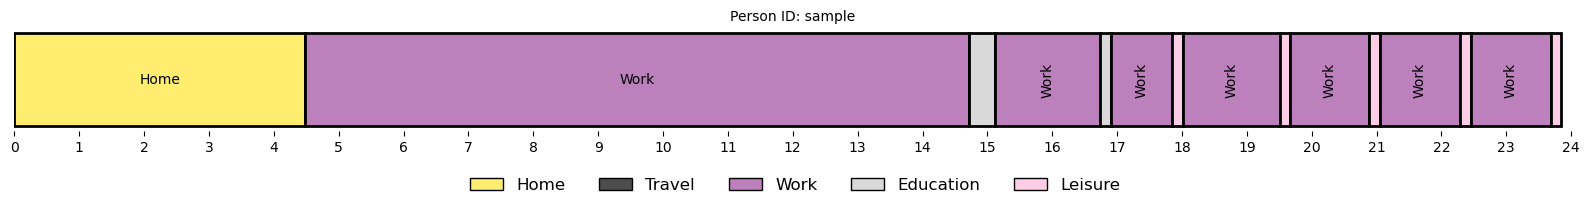

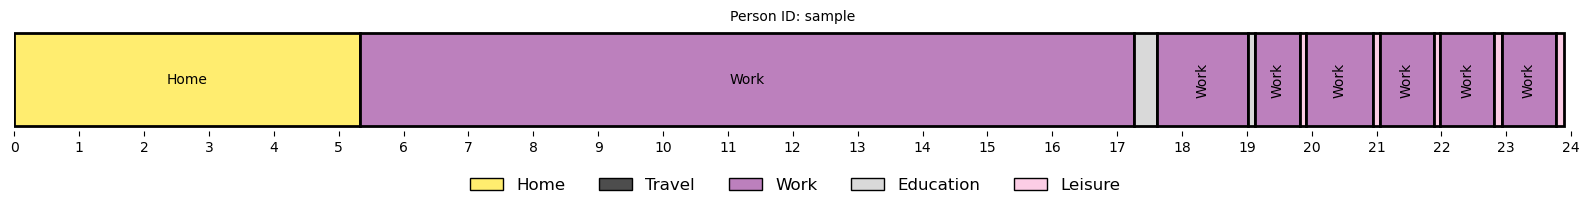

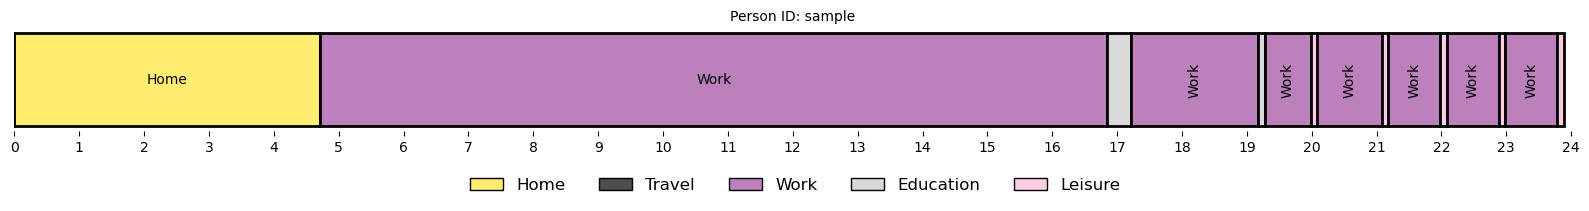

In [11]:
for pid, schedule in synthetic_schedules.groupby("pid"):
    plan = build_plan(schedule)
    if plan is not None:
        plan.plot()